In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import statsmodels.api as sm
import shap

In [36]:
full_games_dataset=pd.read_csv("/content/full_games_dataset.csv")

In [37]:
full_games_dataset.head()

,game_date,interval_duration,zone_5_distance_defenders,zone_5_time_defenders,zone_6_distance_defenders,zone_6_time_defenders,zone_5_distance_midfielders,zone_5_time_midfielders,zone_6_distance_midfielders,zone_6_time_midfielders,...,decelerations_defenders,accelerations_midfielders,decelerations_midfielders,accelerations_attackers,decelerations_attackers,possession,TotalxG,opponent_team_xG,xG_diff,xPts
0,03/09/2023 17:00,5887,2194.8595,363.7,775.1448,101.8,2368.6880,397.4,508.2946,68.6,...,209,579,259,304,130,0.57,1.67,0.60,1.07,2.205
1,17/09/2023 17:01,6470,2171.3559,359.2,673.0986,89.4,2400.1303,400.5,516.6199,70.3,...,188,613,239,192,78,0.65,1.72,1.88,-0.16,1.413
2,27/09/2023 17:02,6016,2028.3958,338.0,525.9290,70.2,2344.5552,390.0,565.8949,74.8,...,239,598,225,295,130,0.62,2.00,0.32,1.68,2.599
3,01/10/2023 17:16,5949,1826.9987,303.0,542.2032,71.5,1959.3291,328.4,337.9914,45.5,...,200,557,236,377,152,0.51,1.62,1.70,-0.08,1.266
4,25/11/2023 18:00,5765,1657.3516,275.4,467.7862,62.4,2240.9246,374.6,410.6001,55.2,...,154,519,221,238,94,0.60,2.03,1.02,1.01,2.159


In [38]:
full_games_dataset = pd.read_csv("/content/full_games_dataset.csv")
full_games_dataset = full_games_dataset.drop(['game_date','interval_duration','TotalxG','opponent_team_xG','xG_diff'],axis=1)
full_games_dataset = full_games_dataset.reset_index(drop=True)

In [39]:
X = full_games_dataset.drop(columns=['xPts'])
y = full_games_dataset['xPts']
scaler = StandardScaler()

In [40]:
def plot_scatter(df, target_col, variable_col):
    """
    Generates a scatter plot between the target column and a specified variable column.

    Args:
        df: pandas DataFrame.
        target_col: Name of the target column.
        variable_col: Name of the variable column to plot against the target.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=target_col, y=variable_col)
    plt.title(f'{variable_col} vs {target_col}')
    plt.xlabel(target_col)
    plt.ylabel(variable_col)
    plt.grid(True)
    if target_col == 'possession':
      plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
      plt.xlabel('Possession (%)')
    plt.show()

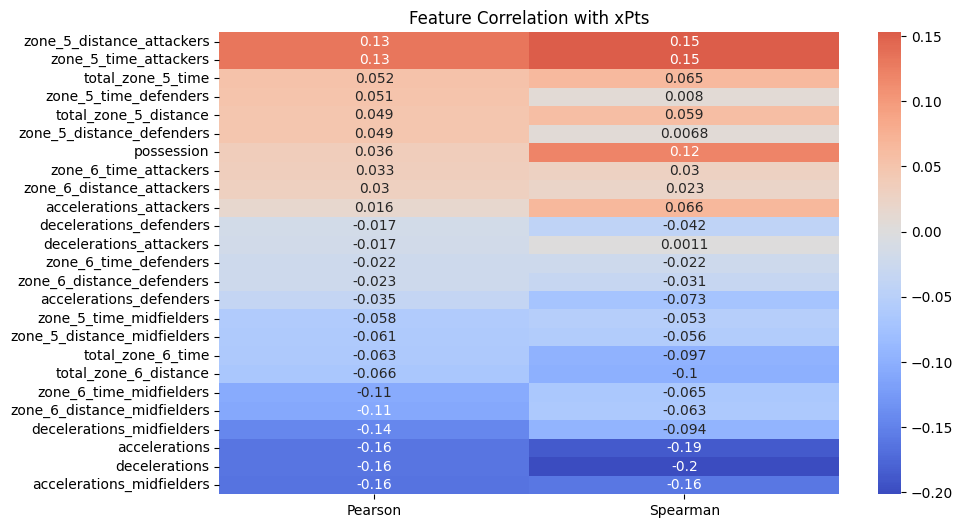

In [42]:
# Pearson correlation
pearson_corr = X.corrwith(y)
spearman_corr = X.corrwith(y, method='spearman')
plt.figure(figsize=(10, 6))

# Combine Pearson and Spearman into a DataFrame and plot heatmap
corr_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})
sorted_features_corr = corr_df.reindex(corr_df['Pearson'].sort_values(ascending=False).index)
sns.heatmap(sorted_features_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation with xPts")
plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [44]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [45]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [66]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Keep only top 10 features most correlated with y
selector = SelectKBest(score_func=f_regression, k=5)
model = LinearRegression()

pipe = make_pipeline(selector, model)
pipe.fit(X_train, y_train)


Pipeline(steps=[('selectkbest',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x787f298c8fe0>)),
                ('linearregression', LinearRegression())])

In [67]:
pred = pipe.predict(X_test)
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
mad = mean_absolute_error(y_test, pred)

print(f"R² Score: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAD: {mad: .3f}")

# ---- Optional: view selected features ----
mask = selector.get_support()
selected_features = X.columns[mask]
print("\nSelected features:")
print(selected_features.tolist())

R² Score: -0.149
MSE: 0.435
MAD:  0.584

Selected features:
['zone_6_distance_midfielders', 'zone_6_time_midfielders', 'total_zone_6_distance', 'total_zone_6_time', 'accelerations']


In [68]:
# Define the models and their parameter grids for Grid Search
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1.0, 10.0, 100]}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [None, 5, 10, 15]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}
    }
}

results = {}

for model_name, model_info in models.items():
    print(f"Running Grid Search for {model_name}...")
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=4, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    pred = best_model.predict(X_test)
    r2 = r2_score(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    mad = mean_absolute_error(y_test, pred)

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'test_r2': r2,
        'test_mse': mse,
        'test_mad': mad
    }
    print(f"Finished Grid Search for {model_name}. Test R-squared: {r2:.4f}, Test MSE: {mse:.4f}, Test MAD: {mad:.4f}")

Running Grid Search for Linear Regression...
Finished Grid Search for Linear Regression. Test R-squared: -1.0104, Test MSE: 0.7614, Test MAD: 0.7212
Running Grid Search for Ridge...
Finished Grid Search for Ridge. Test R-squared: -0.1708, Test MSE: 0.4434, Test MAD: 0.5885
Running Grid Search for Lasso...
Finished Grid Search for Lasso. Test R-squared: -0.0969, Test MSE: 0.4154, Test MAD: 0.5486
Running Grid Search for ElasticNet...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.825e-02, tolerance: 1.511e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.799e-03, tolerance: 1.319e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.878e+00, tolerance: 1.575e

Finished Grid Search for ElasticNet. Test R-squared: -0.1014, Test MSE: 0.4172, Test MAD: 0.5499
Running Grid Search for Decision Tree...
Finished Grid Search for Decision Tree. Test R-squared: -1.8479, Test MSE: 1.0786, Test MAD: 0.9243
Running Grid Search for Random Forest...
Finished Grid Search for Random Forest. Test R-squared: -0.1105, Test MSE: 0.4206, Test MAD: 0.5629


In [69]:
import pandas as pd

results_df = pd.DataFrame(results).T
display(results_df)

best_model_name = results_df['test_r2'].idxmax()
print(f"\nBest performing model on the test set based on R-squared: {best_model_name}")
print("Results for the best model:")
display(results_df.loc[best_model_name])

,best_params,test_r2,test_mse,test_mad
Linear Regression,{},-1.010434,0.761431,0.72122
Ridge,{'alpha': 100},-0.170752,0.44341,0.588523
Lasso,{'alpha': 10.0},-0.096887,0.415435,0.548566
ElasticNet,"{'alpha': 10.0, 'l1_ratio': 0.9}",-0.101426,0.417154,0.549926
Decision Tree,{'max_depth': None},-1.847926,1.078623,0.924333
Random Forest,"{'max_depth': 5, 'n_estimators': 50}",-0.110489,0.420586,0.562897



Best performing model on the test set based on R-squared: Lasso
Results for the best model:


,Lasso
best_params,{'alpha': 10.0}
test_r2,-0.096887
test_mse,0.415435
test_mad,0.548566
